In [19]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras import models,layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom


import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import functions_ai

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1) Setup 

In [21]:
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')] #verschillende metrics vergelijken

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

## 2) Build your initial model

In [22]:
custom_preprocessing = functions_ai.custom_preprocessing
BATCH_SIZE = 128
IMG_HEIGHT = IMG_WIDTH = 128 #heb dit veranderd naar 128
EPOCHS = 30
dropout_rate = 0.5

In [23]:


#set the paths/directories
path = pathlib.Path('covid xray')
train_dir = os.path.join(path, 'train') 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)

In [24]:
train_data_gen = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             label_mode='binary',
                                                             batch_size=BATCH_SIZE,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH))
val_data_gen = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           label_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=(IMG_HEIGHT, IMG_WIDTH))
test_data_gen = tf.keras.utils.image_dataset_from_directory(test_dir, 
                                                            label_mode = 'binary', 
                                                            batch_size = BATCH_SIZE,
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            #shuffle = False) #set shuffle = False when running/computing the covariance matrix
                                                            shuffle = True) #set shuffle = True for visual evaluation 

                                                             #when changed remember to run the 3 blocks code below

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [25]:
def preprocess_image(transform):
    
    def _preprocess(image, label):
        return transform(image), label
        
    return _preprocess

In [26]:
rescale = Rescaling(1 / 255)

In [27]:
train_data_preproc = train_data_gen.map(preprocess_image(rescale))
val_data_preproc = val_data_gen.map(preprocess_image(rescale))
test_data_preproc = test_data_gen.map(preprocess_image(rescale))

In [28]:
train_data_preproc = train_data_preproc.cache()
val_data_preproc = val_data_preproc.cache()
test_data_preproc = test_data_preproc.cache()

In [29]:
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(labels[int(label)], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

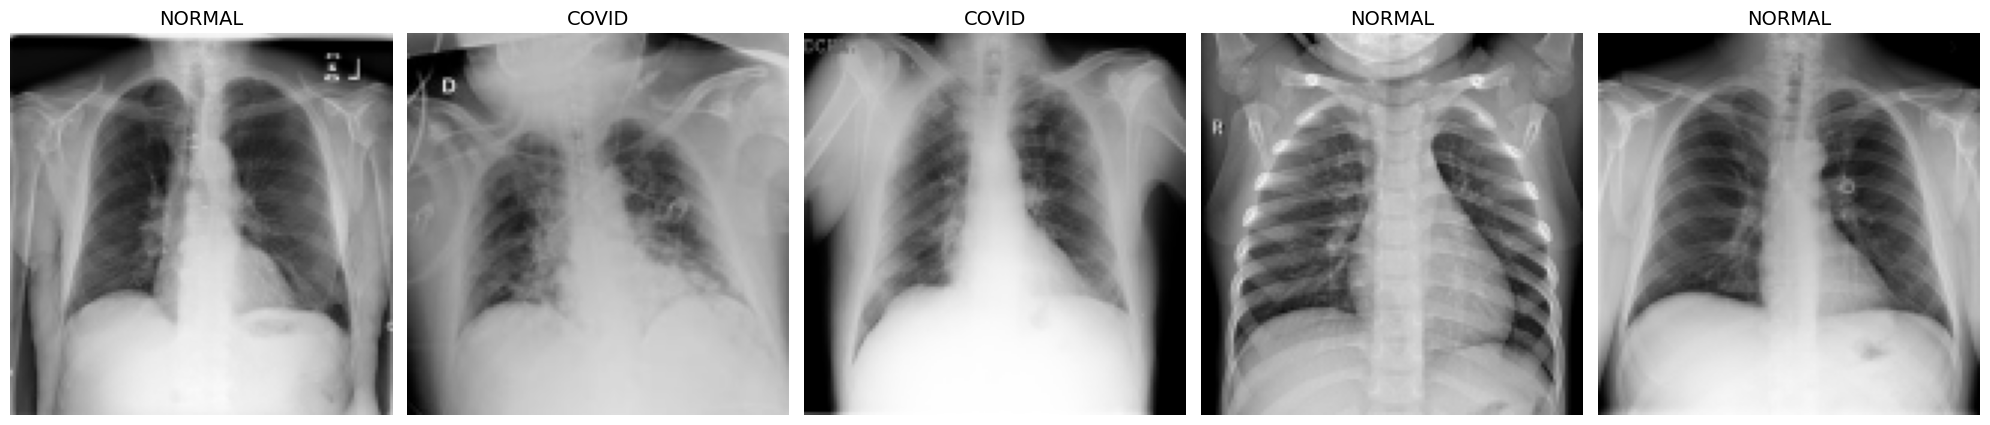

In [30]:
labels = train_data_gen.class_names

first_batch_images, first_batch_labels = next(iter(train_data_preproc))
plot_images(first_batch_images[:5], first_batch_labels[:5])

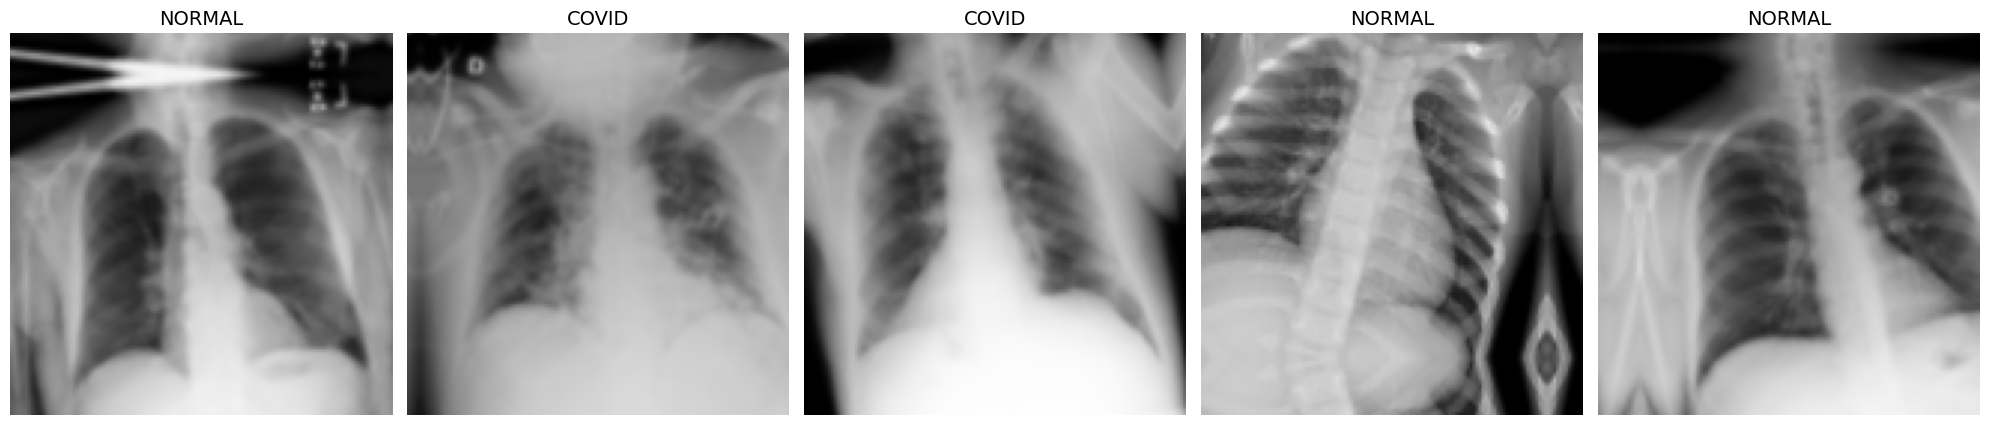

In [31]:
flip =  RandomFlip("horizontal")
rotate = RandomRotation(factor=(-1/24, 1/24))  # of korter: factor=1/12
translate = RandomTranslation(height_factor=0.15, width_factor=0.15)
zoom = RandomZoom(0.1)
augment = Sequential((flip, rotate, translate, zoom))
plot_images(map(augment, first_batch_images[:5]),first_batch_labels[:5]) 
#zou gwn in verslag zetten ja begonnen met die flow_flow from directory dan die ufora melding daarom dit hier implementeren en niet echt gebruiken 
#van de pipeline opgezet in stap 1 (jammerrrrrrr)

In [32]:
base_model=tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="resnet50v2",
)

base_model.trainable=False

model=Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    flip,
    rotate, 
    translate,
    zoom])

model.add(base_model)


model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

In [34]:
model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,408,321 (154.15 MB)

 Trainable params: 16,843,521 (64.25 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [31]:
history = model.fit(
    train_data_preproc,
    epochs=EPOCHS,
    validation_data=val_data_preproc,
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6411 - auc: 0.6683 - loss: 7.7484 - precision: 0.6338 - recall: 0.6491 - val_accuracy: 0.5875 - val_auc: 0.6679 - val_loss: 4.8993 - val_precision: 0.5487 - val_recall: 0.9850
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7684 - auc: 0.8080 - loss: 2.3634 - precision: 0.7473 - recall: 0.8020 - val_accuracy: 0.7100 - val_auc: 0.8747 - val_loss: 0.9038 - val_precision: 0.6391 - val_recall: 0.9650
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7949 - auc: 0.8604 - loss: 1.1920 - precision: 0.7740 - recall: 0.8232 - val_accuracy: 0.7375 - val_auc: 0.8807 - val_loss: 0.5206 - val_precision: 0.6792 - val_recall: 0.9000
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8240 - auc: 0.8944 - loss: 0.7048 - precision: 0.8179 - recall: 0.8260 - val_accuracy: 0.7800 - val_auc: 0.8634 - val_loss: 0.5463 - val_precision: 0.7523 - val_recall: 0.8350
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 32

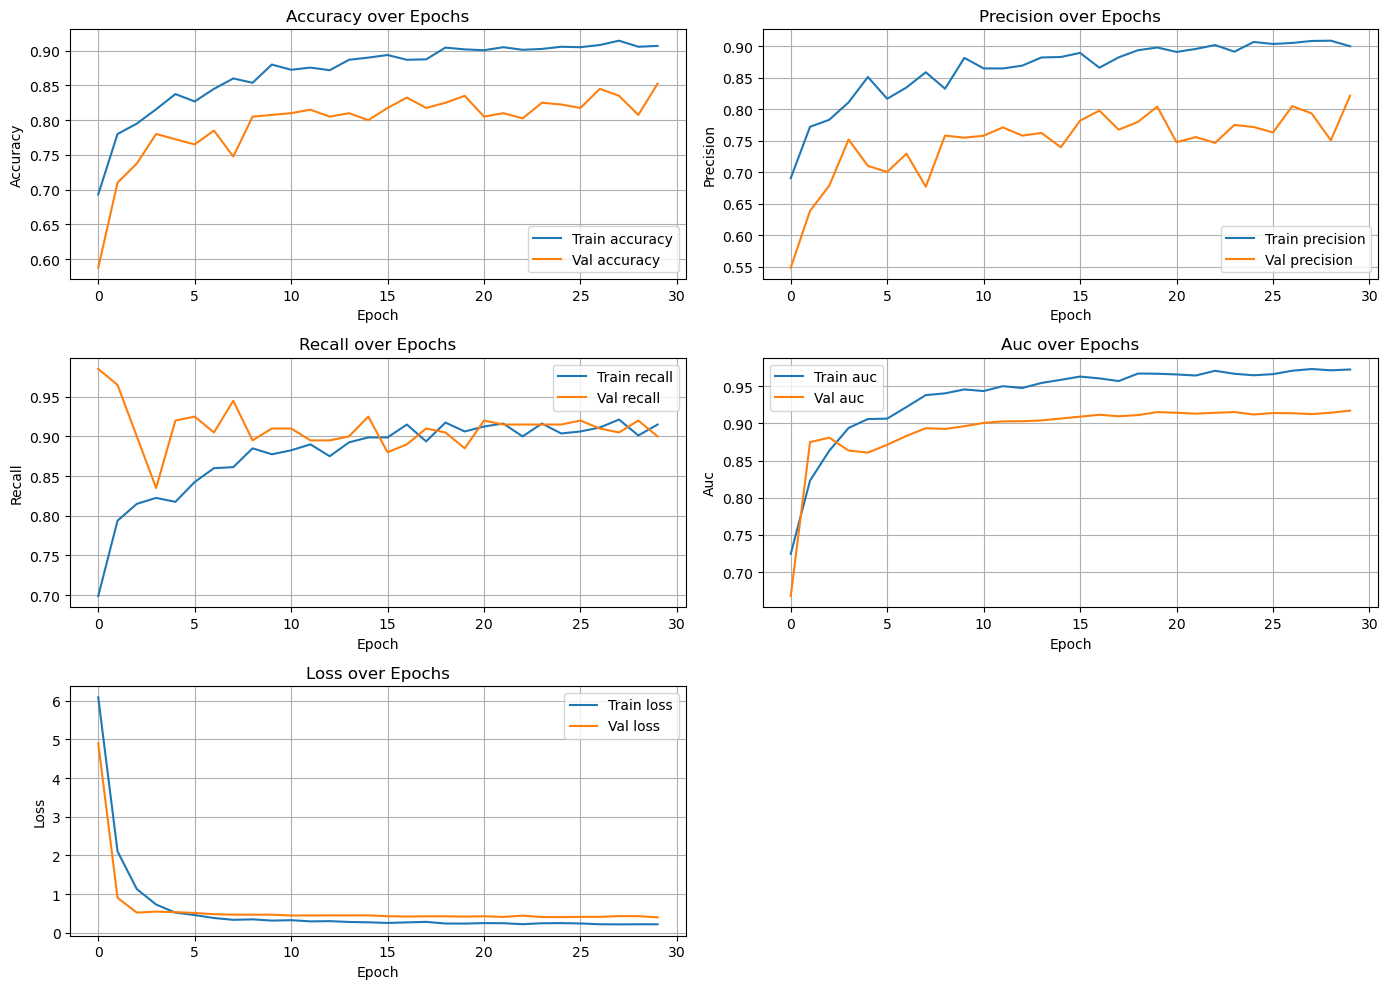

In [34]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc','loss']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 2, i + 1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 4) Hyperparameter tuning

In [42]:
def build_model(batch_size, 
                dropout, 
                learning_rate):
    
    model=models.Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    flip,
    rotate, 
    translate,
    zoom])

    model.add(base_model)


    model.add(layers.Flatten())

    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1,activation='sigmoid'))
   
   
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [40]:
import itertools
import pandas as pd

# Define hyperparameter ranges
dropout_list = [0.5, 0.3, 0.2]
learning_rates = [0.002, 0.001, 0.0005]
batch_size=[32,64,128]


# To store results
results = []
val_accuracy_optimal = 0

# Loop over all combinations
for dp, lr, bs in itertools.product(dropout_list,learning_rates,batch_size):

    print(f"\nTraining with dropout={dp},  learning rate={lr}, batch_size={bs}")
    
    model = build_model(bs,dp,lr)
    

    early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 2, restore_best_weights=True)
    

    train_data_gen_2 = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             label_mode='binary',
                                                             batch_size=bs,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH))
    val_data_gen_2 = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           label_mode='binary',
                                                           batch_size=bs,
                                                           image_size=(IMG_HEIGHT, IMG_WIDTH))

    train_data_preproc_2 = train_data_gen_2.map(preprocess_image(rescale))
    val_data_preproc_2 = val_data_gen_2.map(preprocess_image(rescale))


    train_data_preproc_2 = train_data_preproc_2.cache()
    val_data_preproc_2 = val_data_preproc_2.cache()

    history = model.fit(
        train_data_preproc_2,
        validation_data=val_data_preproc_2, 
        epochs=30,
        batch_size= bs,
        callbacks=[early_stop],
        verbose=1)

    # Save last epoch metrics
    last_epoch = -1
    results.append({
    'batch size': bs, 
    'dropout': dp,
    'learning_rate': lr,
    'val_accuracy': history.history['val_accuracy'][last_epoch],
    'val_precision': history.history['val_precision'][last_epoch],
    'val_recall': history.history['val_recall'][last_epoch],
    'val_auc': history.history['val_auc'][last_epoch],
    })

    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > val_accuracy_optimal:
        val_accuracy_optimal = val_accuracy
        hyperparameters_optimal = [dp,bs,lr]

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("grid_search_hyperparams_results.task3.csv", index=False)



Training with dropout=0.5,  learning rate=0.002, batch_size=32
Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 833ms/step - accuracy: 0.6941 - auc: 0.7087 - loss: 9.1924 - precision: 0.6905 - recall: 0.7078 - val_accuracy: 0.7775 - val_auc: 0.8381 - val_loss: 1.2339 - val_precision: 0.7511 - val_recall: 0.8300
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - accuracy: 0.7948 - auc: 0.8461 - loss: 1.9666 - precision: 0.7844 - recall: 0.8112 - val_accuracy: 0.7925 - val_auc: 0.8791 - val_loss: 0.5244 - val_precision: 0.7671 - val_recall: 0.8400
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.8133 - auc: 0.8883 - loss: 0.7356 - precision: 0.8129 - recall: 0.8140 - val_accuracy: 0.6875 - val_auc: 0.8542 - val_loss: 0.5755 - val_precision: 0.8947 - val_recall: 0.4250
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 843ms/step - accuracy: 0.8084 - auc: 0.8899 - loss: 0.5363 - precision: 0.8090 - rec

### Training pretrained model

In [43]:
pre_trained_model = build_model(32,0.2,0.002)
early_stop= tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5, restore_best_weights=True)
train_data_gen_3 = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             label_mode='binary',
                                                             batch_size= 32,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH))
val_data_gen_3 = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           label_mode='binary',
                                                           batch_size=32,
                                                           image_size=(IMG_HEIGHT, IMG_WIDTH))

train_data_preproc_3 = train_data_gen_3.map(preprocess_image(rescale))
val_data_preproc_3 = val_data_gen_3.map(preprocess_image(rescale))
combined_data_preproc = train_data_preproc_3.concatenate(val_data_preproc_3).shuffle(buffer_size=10000,  # possibly larger than dataset size.
                                                                            reshuffle_each_iteration=True)


train_data_preproc_3 = train_data_preproc_3.cache()
val_data_preproc_3 = val_data_preproc_3.cache()

history_pre_trained = pre_trained_model.fit(
        combined_data_preproc, 
        epochs=30,
        batch_size= 32,
        callbacks=[early_stop],
        verbose=1)


Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Epoch 1/30


KeyboardInterrupt: 

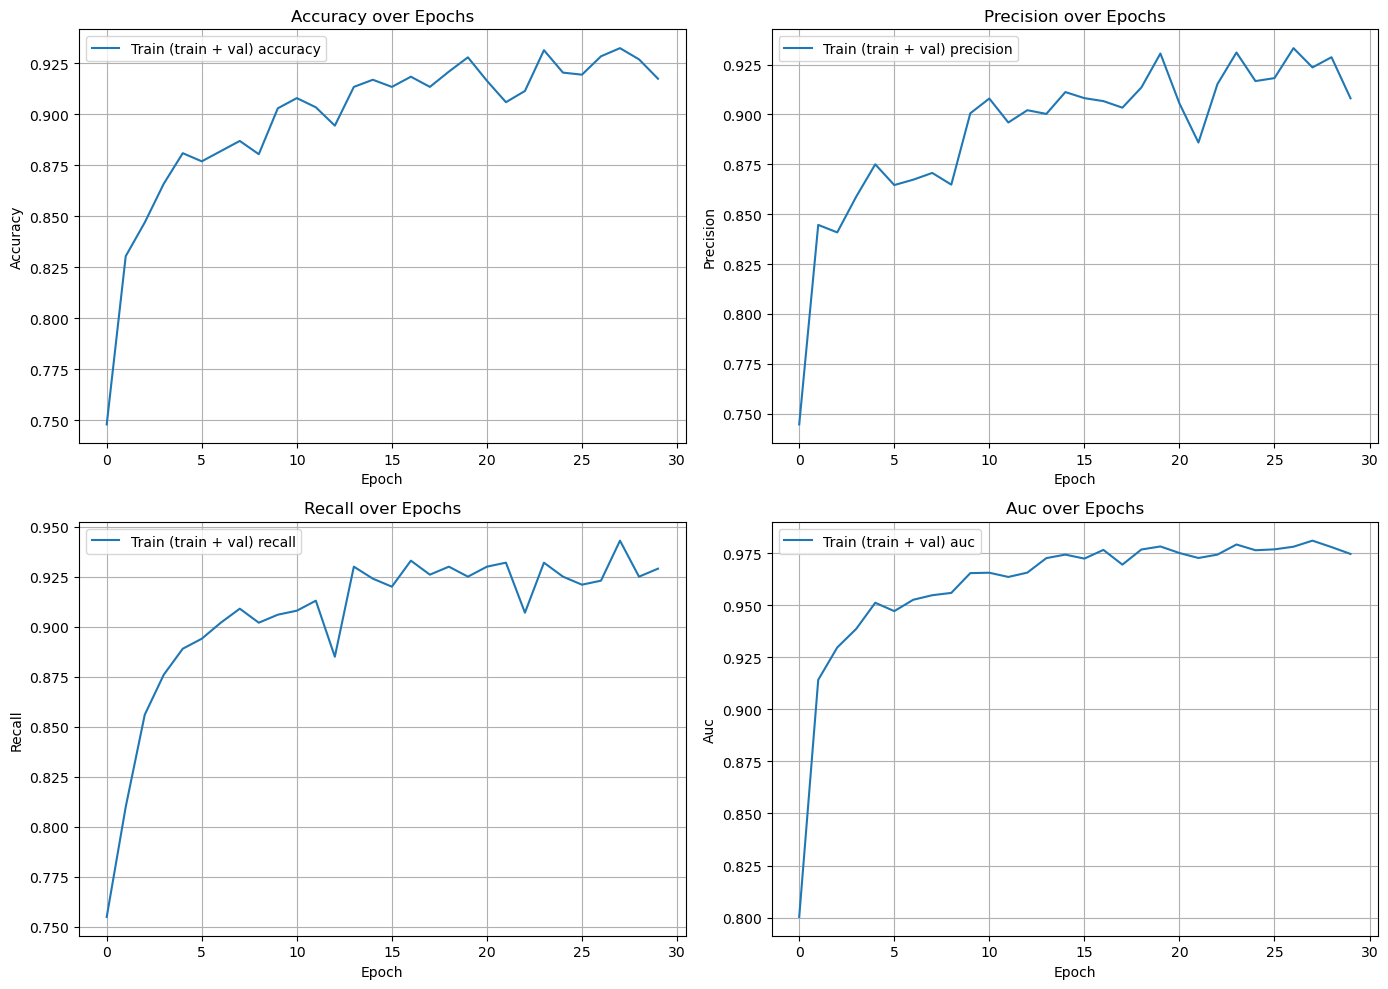

In [44]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.plot(history_pre_trained.history[metric], label=f'Train (train + val) {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

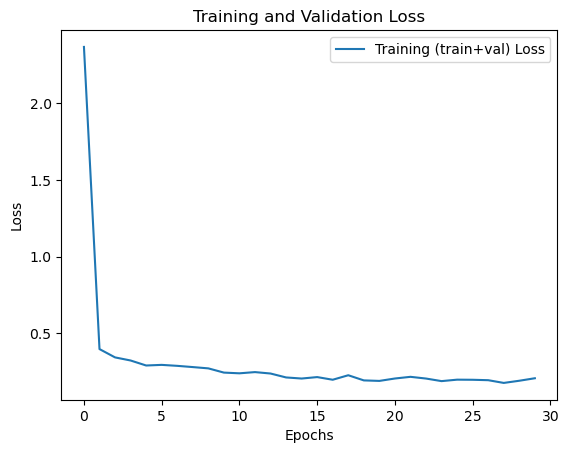

In [45]:
plt.plot(history_pre_trained.history['loss'], label='Training (train+val) Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('retrained accuracy v2.png')
plt.show()

In [46]:
from tensorflow.keras.models import load_model

pre_trained_model.save("pre_trained_model.keras")
pretrainedmodel = tf.keras.models.load_model('pre_trained_model.keras')

In [47]:
final_results = pretrainedmodel.evaluate(test_data_preproc) #-> [loss, accuracy, precision, recall, auc]
final_loss = final_results[0]
final_acc = final_results[1]
final_precision = final_results[2]
final_recall = final_results[3]
final_auc = final_results[4]

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 976ms/step - accuracy: 0.8557 - auc: 0.9527 - loss: 0.4133 - precision: 0.7807 - recall: 0.9933


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 818ms/step


2025-05-01 16:37:45.672549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


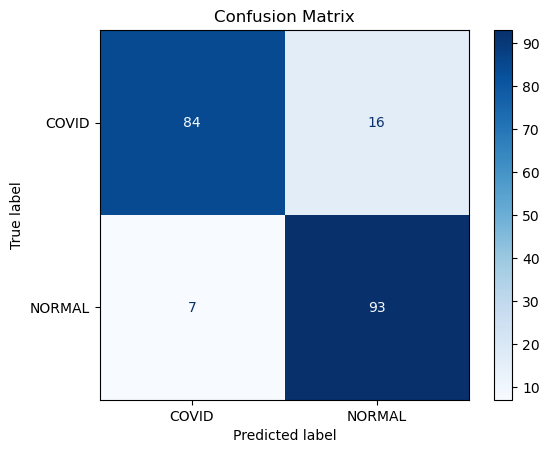

In [48]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

true_labels = []
predicted_labels = []

for images, labels in test_data_preproc:
    predictions = (pretrainedmodel.predict(images) > 0.8).astype("int32").flatten() #VERSLAG : eigenlijk is treshold 0,5 
    #ma je krijgt u COVID COVID wel dik omhoog door hem hoger te zetten (denk dat hoger = hogere pixel waarden -> covid (ma nie zeker zie deel 1))
    #goal = true negatives as high as possible (COVID -> COVID) <=> COVID -> Normal should be as low as possible
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predictions)

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COVID", "NORMAL"])  # of jouw labels
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

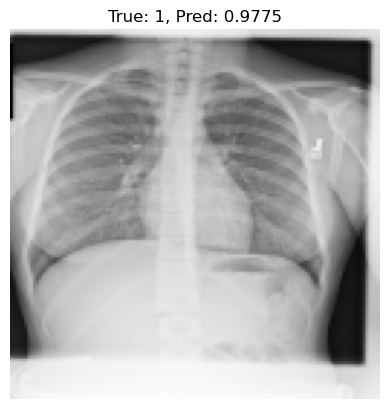

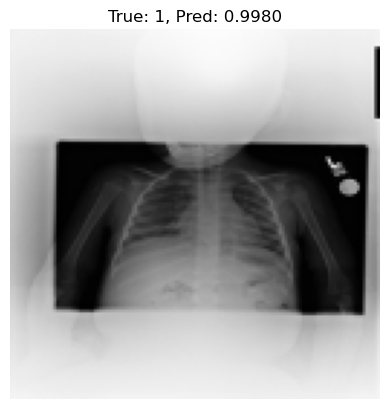

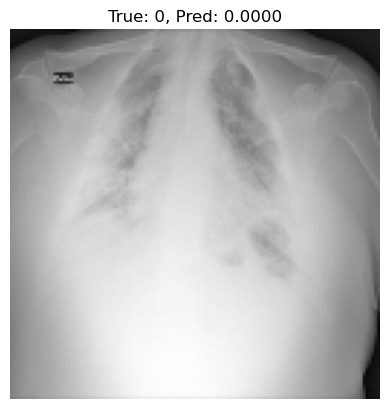

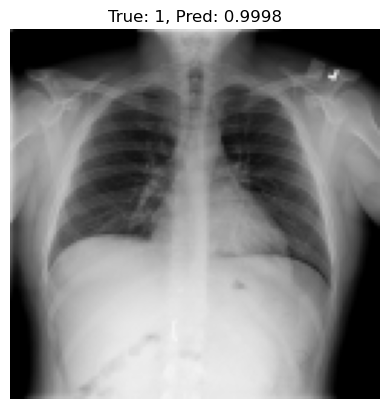

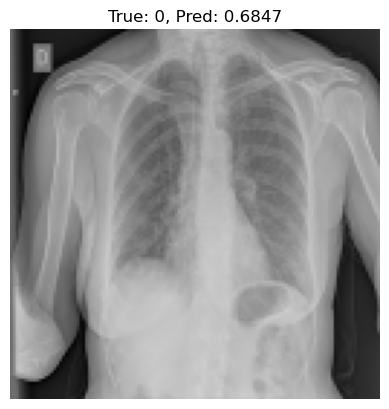

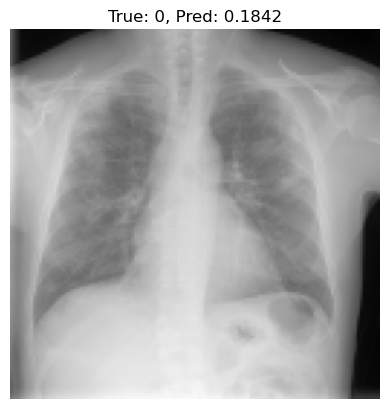

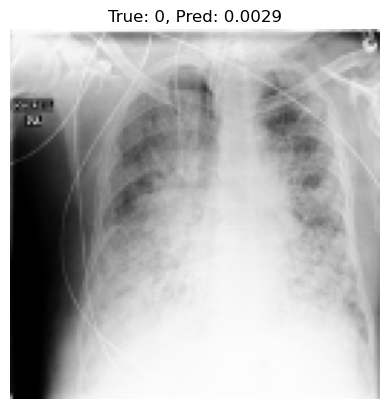

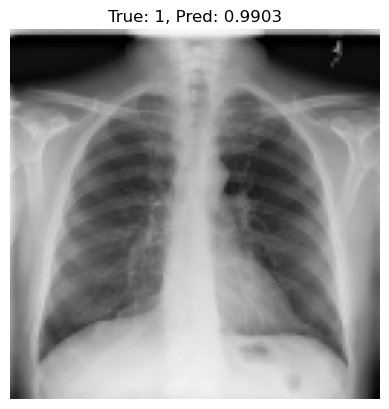

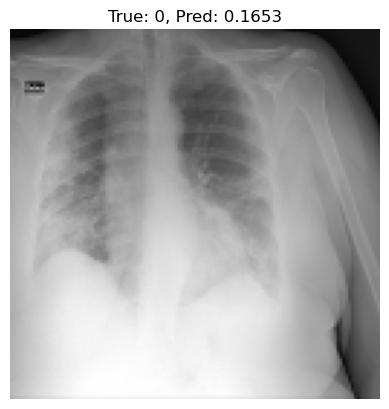

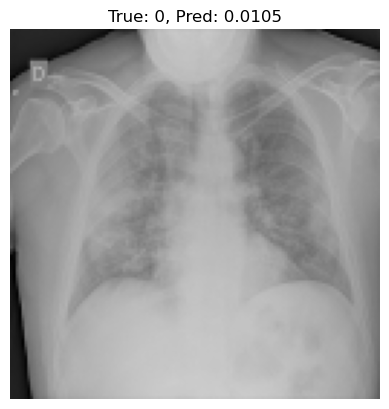

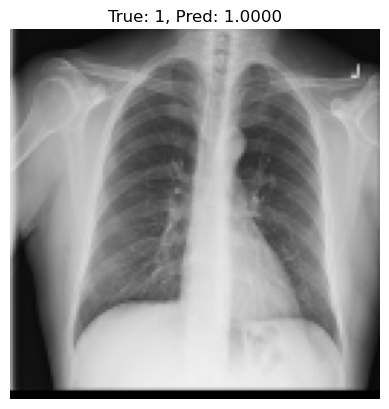

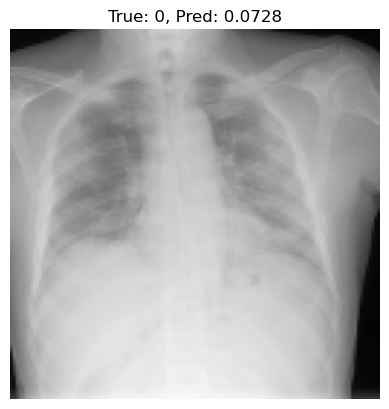

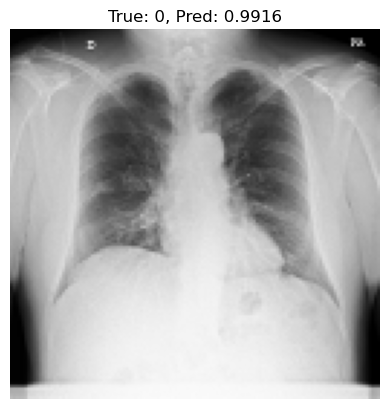

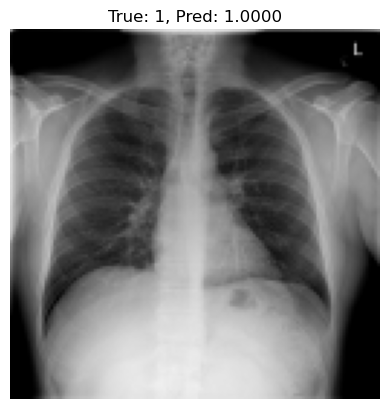

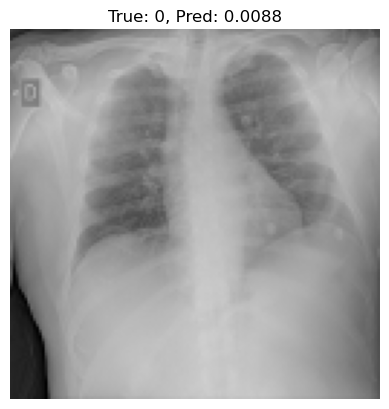

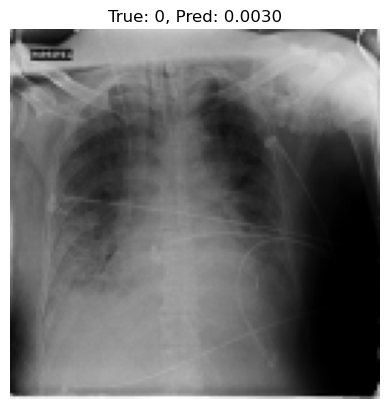

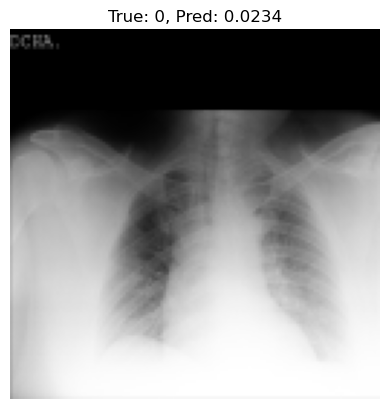

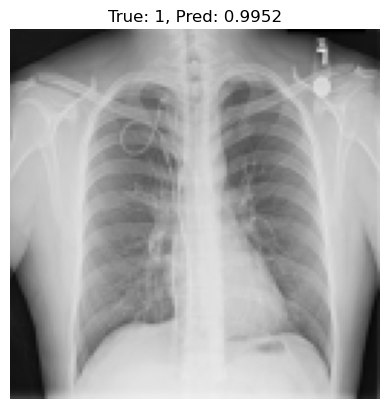

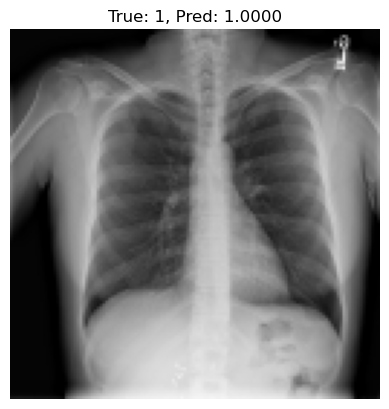

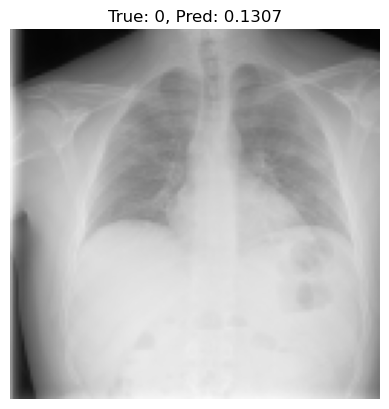

In [50]:
x_batch, y_batch = next(iter(test_data_preproc))  # gebruik iter() om netjes te itereren

y_pred = pretrainedmodel.predict(x_batch, verbose=0)

for i in range(20): #zet voor deze de shuffle in test efjes aan!
    img = x_batch[i]
    true_label = y_batch[i]
    pred_label = y_pred[i][0]  # binary classificatie

    plt.figure()
    plt.imshow(img.numpy().squeeze())
    plt.title(f"True: {int(true_label)}, Pred: {pred_label:.4f}")
    plt.axis("off")
    plt.show()


## 6) Finetuning the entire model

In [44]:
base_model=tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="resnet50v2",
)

base_model.trainable=True

model_finetune=models.Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    flip,
    rotate, 
    translate,
    zoom])

model_finetune.add(base_model)


model_finetune.add(layers.Flatten())

model_finetune.add(layers.Dense(512,activation='relu'))
model_finetune.add(layers.Dropout(0.5))

model_finetune.add(layers.Dense(128,activation='relu'))
model_finetune.add(layers.Dropout(0.5))

model_finetune.add(layers.Dense(1,activation='sigmoid'))

In [45]:
model_finetune.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,408,321 (154.15 MB)

 Trainable params: 40,362,881 (153.97 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

In [37]:
model_finetune.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

NameError: name 'model_finetune' is not defined

In [58]:
history_finetune = model_finetune.fit(
        combined_data_preproc, 
        epochs=30,
        batch_size= 32,
        verbose=1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.5372 - auc: 0.5518 - loss: 2.6471 - precision: 0.5530 - recall: 0.3966
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.4843 - auc: 0.4872 - loss: 2.4139 - precision: 0.4864 - recall: 0.7452
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.5130 - auc: 0.4760 - loss: 1.9377 - precision: 0.5123 - recall: 0.4806
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.4990 - auc: 0.5084 - loss: 1.3007 - precision: 0.5322 - recall: 0.3659
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5165 - auc: 0.5272 - loss: 0.8026 - precision: 0.7310 - recall: 0.0859
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.5215 - auc: 0.4801 - loss: 0.8875 - precision: 0.7498 - recall: 0.0661
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.5319 - auc: 0.5318 - loss: 0.8121 - precision: 0.7638 - recall: 0.0811
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/st

KeyboardInterrupt: 

In [46]:
#lowering the learning rate
optimizer_lower_lr = tf.keras.optimizers.Adam(learning_rate=0.001)

model_finetune.compile(
        optimizer=optimizer_lower_lr,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

history_finetune_lowerlr = model_finetune.fit(
        combined_data_preproc, 
        epochs=30,
        batch_size= 32,
        verbose=1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.7196 - auc: 0.7374 - loss: 1.0273 - precision: 0.7478 - recall: 0.6764
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8118 - auc: 0.8872 - loss: 0.5727 - precision: 0.8145 - recall: 0.8224
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.6173 - auc: 0.6798 - loss: 1.0242 - precision: 0.7233 - recall: 0.3686
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.7629 - auc: 0.8288 - loss: 0.7065 - precision: 0.7595 - recall: 0.7693
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6969 - auc: 0.7692 - loss: 0.9237 - precision: 0.6632 - recall: 0.8058
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7301 - auc: 0.8381 - loss: 0.5652 - precision: 0.7010 - recall: 0.8151
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7412 - auc: 0.8274 - loss: 0.6499 - precision: 0.8358 - recall: 0.6278
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/st

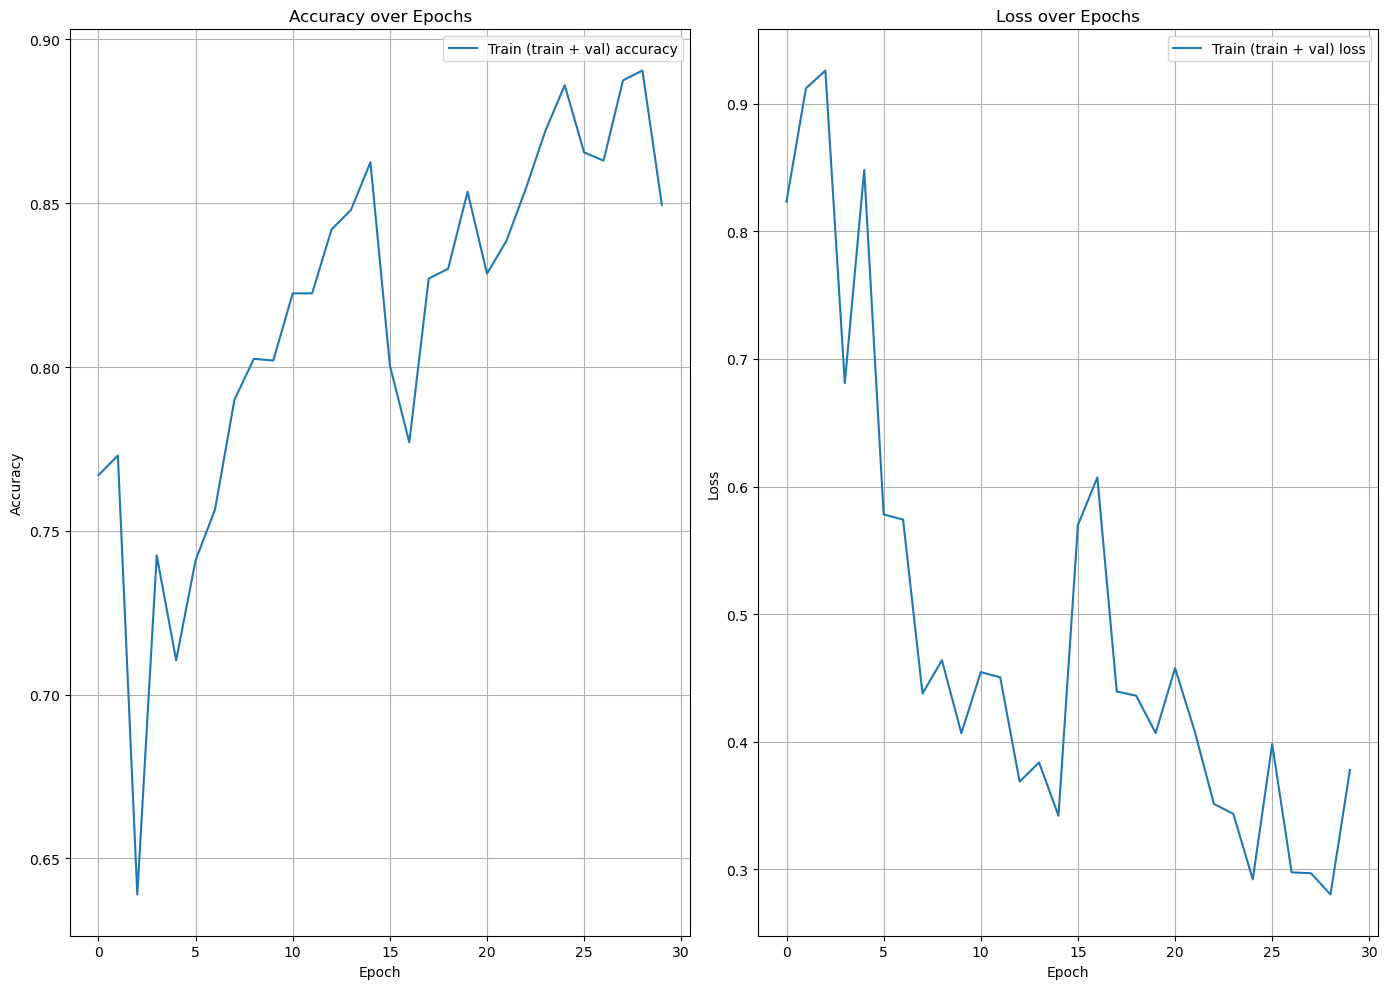

In [47]:
# List of metrics to plot
metrics_to_plot = ['accuracy','loss']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i + 1)
    plt.plot(history_finetune_lowerlr.history[metric], label=f'Train (train + val) {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()